Лысенко Никита 4.8 2020

# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

Основным методом обучения я выбрал случайный лес.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

In [3]:
pd.set_option('display.max_columns', None)

## Начнём знакомиться с данными

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
y = train['SalePrice']

In [5]:
train.shape

(1460, 81)

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Имеется 81 признак, из которых 38 числовых и 43 категориальных:

In [8]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [9]:
len(numeric_columns)

38

Также среди числовых признаков есть 3 категориальных, которые необходимо отделить. 

In [10]:
object_int_columns = ['MSSubClass', 'OverallQual', 'OverallCond']

In [11]:
numeric_columns = numeric_columns.drop(object_int_columns)
numeric_columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [12]:
object_columns = train.select_dtypes(include=['object']).columns
object_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [13]:
len(object_columns)

43

## Подготовка данных

Для успешного обучения нашей модели необходимо оба датасета привести в подобающий вид. 

Обработка данных разделяется на несколько этапов:

    1) Обработка пропущенных значений
    2) Удаление выбросов
    3) Нормализация данных
    4) Feature Engineering
    5) Трансформация искажённых числовых признаков
    6) Удаление признаков с высоким коэффициентом корреляции
    7) Превращение категориальных признаков в числовые 
    
Так как в нашем датасете довольно мало данных (1460 объектов), важно их сохранить по максимуму.

### 1. Обработка пропущенных значений

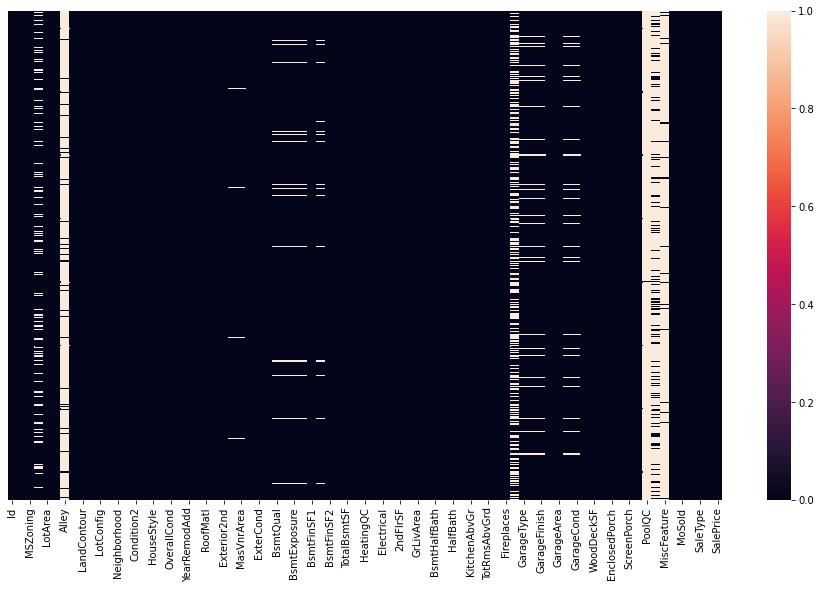

In [14]:
plt.figure(figsize=(16,9))
sns.heatmap(train.isnull(), yticklabels=False)

График heatmap по пустым значениям позволяет увидеть, что происходит с нашими данными. Чёрные области - наличие какого-либо значения, а белые - отсутствие. На глаз видно, что имеется 4 почти белых столбца, означающие почти полное отсутсвие значений. 

In [15]:
def calculate_null_values(df):
    """ Функция для подсчёта пропущенных значений. """
    res = dict()
    for col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            null_percent = round(null_count / df.shape[0] * 100, 4)
            res[col] = (null_count, null_percent)
            print('{}:{} \t{}, \t{}%'.format(col, '\t' if len(col) < 7 else '', null_count, null_percent))
    return res

#### Заполенение пропусков в обучающей выборке train.csv

(Название колонки: количество пропусков, % от общего числа строк)

In [16]:
null_values_train = calculate_null_values(train)

LotFrontage: 	259, 	17.7397%
Alley:	 	1369, 	93.7671%
MasVnrType: 	8, 	0.5479%
MasVnrArea: 	8, 	0.5479%
BsmtQual: 	37, 	2.5342%
BsmtCond: 	37, 	2.5342%
BsmtExposure: 	38, 	2.6027%
BsmtFinType1: 	37, 	2.5342%
BsmtFinType2: 	38, 	2.6027%
Electrical: 	1, 	0.0685%
FireplaceQu: 	690, 	47.2603%
GarageType: 	81, 	5.5479%
GarageYrBlt: 	81, 	5.5479%
GarageFinish: 	81, 	5.5479%
GarageQual: 	81, 	5.5479%
GarageCond: 	81, 	5.5479%
PoolQC:	 	1453, 	99.5205%
Fence:	 	1179, 	80.7534%
MiscFeature: 	1406, 	96.3014%


In [17]:
len(null_values_train)

19

В обучающей выборке имеем 19 признаков c пропущенными значениями 

Глядя на heatmap и процентное соотношение пропусков в датасете, можно сделать следующие выводы:

    1) Есть 4 признака ('Alley', 'PoolQC', 'Fence', 'MiscFeature'), количество пропусков в которых слишком велико, следовательно от них можно избавиться;
    2) Один признак 'FireplaceQu' имеет около 50% пропусков. Соответственно, относительно этого признака нужно будет принять исключительное решение;
    3) Подавляющее большинство признаков имеют небольшой процент пропусков, поэтому есть смысл "побороться" за такие данные.

In [18]:
# 1. избавляемся от "плохих" признаков в обеих выборках
to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(to_drop, axis=1, inplace=True)
object_columns = object_columns.drop(to_drop)

In [19]:
train.shape

(1460, 77)

In [20]:
# 2. более подробно посмотрим на признак 'FireplaceQu'
train['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Признак 'FireplaceQu' или Fireplace quality описывает качество домашнего камина, следовательно, пропущенные признаки означают отсутствие камина как такогого. Лучшим способом "борьбы" в данной ситуации будет ввести новую категорию "Na".

In [21]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('Na')

In [22]:
# 3. Обрабатываем остальные пропуски

In [23]:
null_values_train = calculate_null_values(train)

LotFrontage: 	259, 	17.7397%
MasVnrType: 	8, 	0.5479%
MasVnrArea: 	8, 	0.5479%
BsmtQual: 	37, 	2.5342%
BsmtCond: 	37, 	2.5342%
BsmtExposure: 	38, 	2.6027%
BsmtFinType1: 	37, 	2.5342%
BsmtFinType2: 	38, 	2.6027%
Electrical: 	1, 	0.0685%
GarageType: 	81, 	5.5479%
GarageYrBlt: 	81, 	5.5479%
GarageFinish: 	81, 	5.5479%
GarageQual: 	81, 	5.5479%
GarageCond: 	81, 	5.5479%


In [24]:
train[null_values_train.keys()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrType    1452 non-null   object 
 2   MasVnrArea    1452 non-null   float64
 3   BsmtQual      1423 non-null   object 
 4   BsmtCond      1423 non-null   object 
 5   BsmtExposure  1422 non-null   object 
 6   BsmtFinType1  1423 non-null   object 
 7   BsmtFinType2  1422 non-null   object 
 8   Electrical    1459 non-null   object 
 9   GarageType    1379 non-null   object 
 10  GarageYrBlt   1379 non-null   float64
 11  GarageFinish  1379 non-null   object 
 12  GarageQual    1379 non-null   object 
 13  GarageCond    1379 non-null   object 
dtypes: float64(3), object(11)
memory usage: 159.8+ KB


Имеем 3 числовых и 11 категориальных признаков.

Для числовых признаков пропущенные значения заполним средними значениями:

In [25]:
numeric_missing_columns_train = train[null_values_train.keys()].select_dtypes(include=['float64']).columns
for col in numeric_missing_columns_train:
    train[col] = train[col].fillna(train[col].mean())
    
del numeric_missing_columns_train

С каждым категориальным признаком необходимо провести анализ.

In [26]:
categorical_missing_columns_train = train[null_values_train.keys()].select_dtypes(include=['object']).columns
categorical_missing_columns_train

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

Пропущенные категориальные можно заполнять двумя способами:
    
    1) взять mode и пропуски заполнить самым часто встречающимся значением
    2) ввести новую категорию NA
  
В зависимости от того, за что отвечает признак, мы и будем принимать решение по дальнейшей обработке.

В ходе детального изучения признаков было выяснено, что отсутствующее значение в датасете означает отсутствие признака как такогого в предполагаемом доме. Следовательно, для каждого (за исключением двух) признака необходимо ввести новую категорию. 

В признаке "Electrical" не предусмотрена категория для пустого значения, следовательно, в данной ситуации все пропуски будем заполнять наиболее встречающимся значением, то есть модой.
В признаке "MasVnrType" предусмотрена категория "none" для отсутствующего значения.

In [27]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [28]:
categorical_missing_columns_train = categorical_missing_columns_train.drop('Electrical')
categorical_missing_columns_train = categorical_missing_columns_train.drop('MasVnrType')
for col in categorical_missing_columns_train:
    train[col] = train[col].fillna('Na')
    
del categorical_missing_columns_train

In [29]:
miss_cols_train_add_to_none = ['MasVnrType']
for col in miss_cols_train_add_to_none:
    train[col] = train[col].fillna('None')
    
del miss_cols_train_add_to_none

Проверим, все ли мы обработали пустые значения:

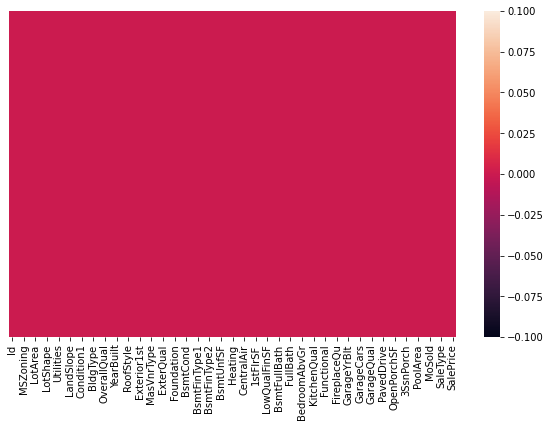

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(), yticklabels=False)

In [31]:
null_values_train = calculate_null_values(train)
null_values_train

{}

Как видно по графику heatmap и функции calculate_null_values(), в тренировочном датасете больше нет пропущенных значений.

### Заполенение пропусков в тестовой выборке test.csv

In [32]:
null_values_test = calculate_null_values(test)

MSZoning: 	4, 	0.2742%
LotFrontage: 	227, 	15.5586%
Alley:	 	1352, 	92.6662%
Utilities: 	2, 	0.1371%
Exterior1st: 	1, 	0.0685%
Exterior2nd: 	1, 	0.0685%
MasVnrType: 	16, 	1.0966%
MasVnrArea: 	15, 	1.0281%
BsmtQual: 	44, 	3.0158%
BsmtCond: 	45, 	3.0843%
BsmtExposure: 	44, 	3.0158%
BsmtFinType1: 	42, 	2.8787%
BsmtFinSF1: 	1, 	0.0685%
BsmtFinType2: 	42, 	2.8787%
BsmtFinSF2: 	1, 	0.0685%
BsmtUnfSF: 	1, 	0.0685%
TotalBsmtSF: 	1, 	0.0685%
BsmtFullBath: 	2, 	0.1371%
BsmtHalfBath: 	2, 	0.1371%
KitchenQual: 	1, 	0.0685%
Functional: 	2, 	0.1371%
FireplaceQu: 	730, 	50.0343%
GarageType: 	76, 	5.209%
GarageYrBlt: 	78, 	5.3461%
GarageFinish: 	78, 	5.3461%
GarageCars: 	1, 	0.0685%
GarageArea: 	1, 	0.0685%
GarageQual: 	78, 	5.3461%
GarageCond: 	78, 	5.3461%
PoolQC:	 	1456, 	99.7944%
Fence:	 	1169, 	80.1234%
MiscFeature: 	1408, 	96.5045%
SaleType: 	1, 	0.0685%


In [33]:
len(null_values_test)

33

В тестовой выборке имеем 33 признака c пропущенными значениями

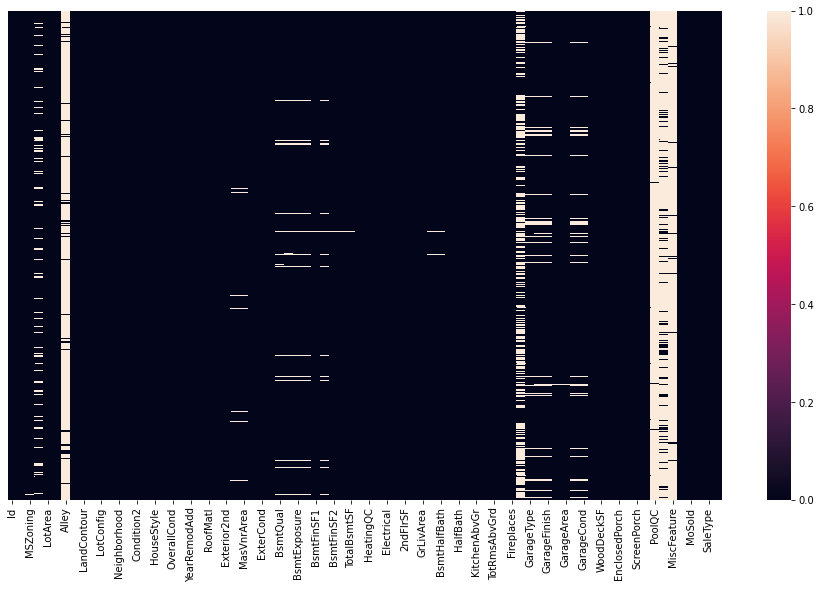

In [34]:
plt.figure(figsize=(16,9))
sns.heatmap(test.isnull(), yticklabels=False)

Имеем 3 числовых и 11 категориальных признаков.

Так же как и в тренировочной, избавляемся от признаков со слишком большим процентом пропусков

In [35]:
# 1. избавляемся от "плохих" признаков в обеих выборках
test.drop(to_drop, axis=1, inplace=True)

In [36]:
null_values_test = calculate_null_values(test)

MSZoning: 	4, 	0.2742%
LotFrontage: 	227, 	15.5586%
Utilities: 	2, 	0.1371%
Exterior1st: 	1, 	0.0685%
Exterior2nd: 	1, 	0.0685%
MasVnrType: 	16, 	1.0966%
MasVnrArea: 	15, 	1.0281%
BsmtQual: 	44, 	3.0158%
BsmtCond: 	45, 	3.0843%
BsmtExposure: 	44, 	3.0158%
BsmtFinType1: 	42, 	2.8787%
BsmtFinSF1: 	1, 	0.0685%
BsmtFinType2: 	42, 	2.8787%
BsmtFinSF2: 	1, 	0.0685%
BsmtUnfSF: 	1, 	0.0685%
TotalBsmtSF: 	1, 	0.0685%
BsmtFullBath: 	2, 	0.1371%
BsmtHalfBath: 	2, 	0.1371%
KitchenQual: 	1, 	0.0685%
Functional: 	2, 	0.1371%
FireplaceQu: 	730, 	50.0343%
GarageType: 	76, 	5.209%
GarageYrBlt: 	78, 	5.3461%
GarageFinish: 	78, 	5.3461%
GarageCars: 	1, 	0.0685%
GarageArea: 	1, 	0.0685%
GarageQual: 	78, 	5.3461%
GarageCond: 	78, 	5.3461%
SaleType: 	1, 	0.0685%


In [37]:
test[null_values_test.keys()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1455 non-null   object 
 1   LotFrontage   1232 non-null   float64
 2   Utilities     1457 non-null   object 
 3   Exterior1st   1458 non-null   object 
 4   Exterior2nd   1458 non-null   object 
 5   MasVnrType    1443 non-null   object 
 6   MasVnrArea    1444 non-null   float64
 7   BsmtQual      1415 non-null   object 
 8   BsmtCond      1414 non-null   object 
 9   BsmtExposure  1415 non-null   object 
 10  BsmtFinType1  1417 non-null   object 
 11  BsmtFinSF1    1458 non-null   float64
 12  BsmtFinType2  1417 non-null   object 
 13  BsmtFinSF2    1458 non-null   float64
 14  BsmtUnfSF     1458 non-null   float64
 15  TotalBsmtSF   1458 non-null   float64
 16  BsmtFullBath  1457 non-null   float64
 17  BsmtHalfBath  1457 non-null   float64
 18  KitchenQual   1458 non-null 

Пропущенные числовые значения также заполним средними значениями:

In [38]:
numeric_missing_columns_test = test[null_values_test.keys()].select_dtypes(include=['float64']).columns
for col in numeric_missing_columns_test:
    test[col] = test[col].fillna(test[col].mean())
    
del numeric_missing_columns_test

##### Теперь заполним пустоты с категориальными значениями. 

In [39]:
categorical_missing_columns_test = test[null_values_test.keys()].select_dtypes(include=['object']).columns
categorical_missing_columns_test

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

В ходе детального изучения признаков в тестовой выборке было выяснено, что решение по устранению пустых объектов необходимо принимать, глядя на описание каждого признака.

    FireplaceQu - вводим новую категорию NA
    MSZoning - mode, заполняем пустоты наиболее встречающимся значением
    Utilities - mode, заполняем пустоты наиболее встречающимся значением
    Exterior1st - mode, заполняем пустоты наиболее встречающимся значением
    Exterior2nd - mode, заполняем пустоты наиболее встречающимся значением
    MasVnrType - есть категория none, в которубю необходимо добавить все пропущенные значения
    BsmtQual - вводим новую категорию NA
    BsmtCond - вводим новую категорию NA
    BsmtExposure - вводим новую категорию NA
    BsmtFinType1 - вводим новую категорию NA
    BsmtFinType2 - вводим новую категорию NA
    KitchenQual - mode, заполняем пустоты наиболее встречающимся значением
    Functional - mode, заполняем пустоты наиболее встречающимся значением
    GarageType - вводим новую категорию NA
    GarageFinish - вводим новую категорию NA
    GarageQual - вводим новую категорию NA
    GarageCond - вводим новую категорию NA
    SaleType - mode, заполняем пустоты наиболее встречающимся значением

In [40]:
miss_cols_test_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 
                       'SaleType']

miss_cols_test_new_cat_NA = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                             'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

miss_cols_test_add_to_none = ['MasVnrType']

In [41]:
for col in miss_cols_test_mode:
    test[col] = test[col].fillna(test[col].mode()[0])

del miss_cols_test_mode

In [42]:
for col in miss_cols_test_new_cat_NA:
    test[col] = test[col].fillna('Na')
    
del miss_cols_test_new_cat_NA

In [43]:
for col in miss_cols_test_add_to_none:
    test[col] = test[col].fillna('None')
    
del miss_cols_test_add_to_none

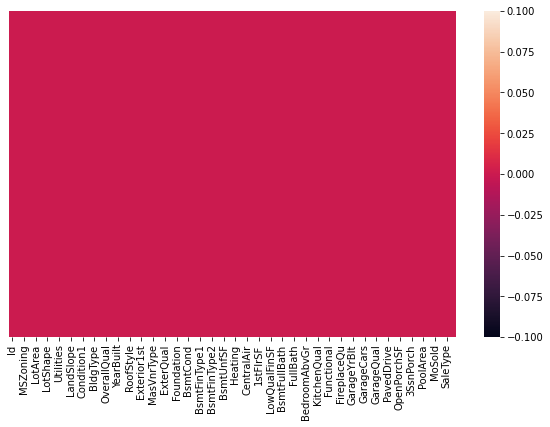

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(), yticklabels=False)

In [45]:
null_values_test = calculate_null_values(test)
null_values_test

{}

Как видно по графику heatmap и функции calculate_null_values(), в тестовом датасете больше нет пропущенных значений.

Первый этап обработки данных завершён.

## 2. Удаление выбросов

In [46]:
# и также практически не чувствителен к выбросам из-за случайного сэмлирования. 

Для того чтобы отследить выбросы, необходимо посмотреть на каждый числовой признак относительно целевого признака. 

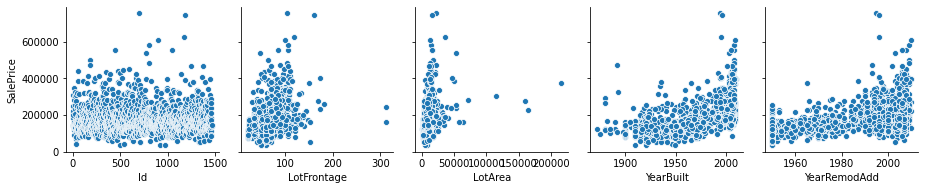

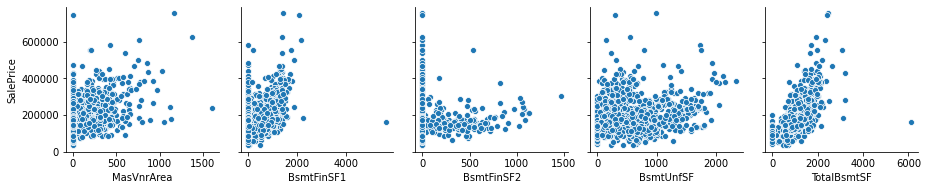

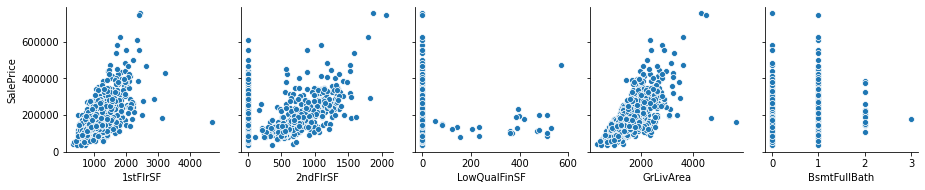

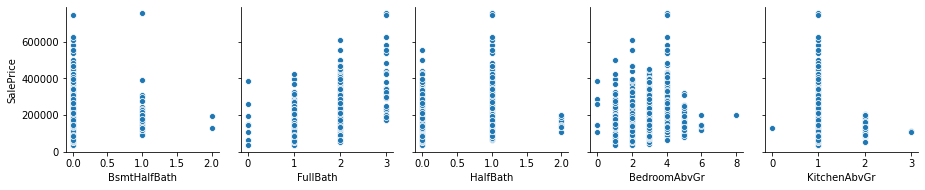

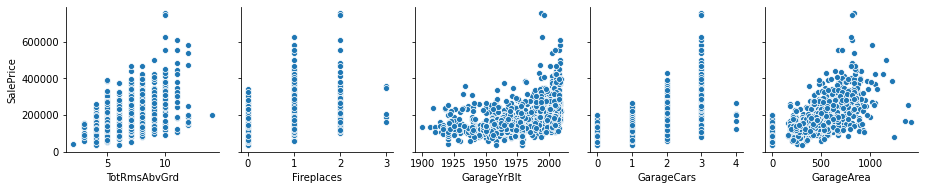

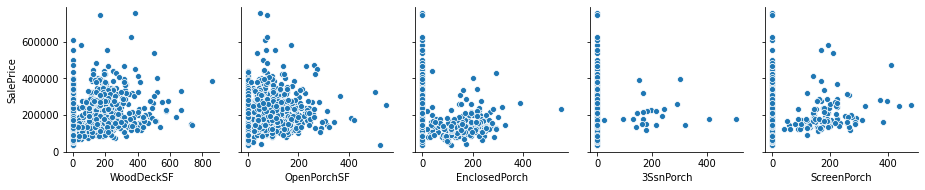

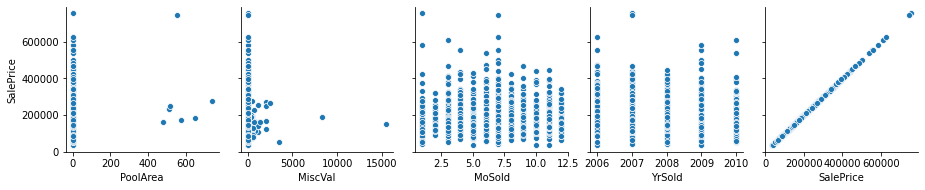

In [47]:
cols5 = []
for i in range(0, len(numeric_columns), 5):
    cols5.append(numeric_columns[i : i + 5])
    
# Далее выыведем графики зависимостей численных признаков от целевой переменной
for x in cols5:
    sns.pairplot(train, y_vars=['SalePrice'], x_vars=x)

Глядя на данные графики, можно сделать выводы о выбросах для каждого признака

Для подавляющего большинства признаков выбросов не наблюдается.
Однако есть признаки, у которых они всё таки наблюдаются:

    "LotArea" > 100000
    "LotFrontage" > 300
    "BsmtFinSF1" > 4000 
    "TotalBsmtSF" > 6000
    "1stFlrSF" > 4000
    "GrLivArea" > 5000
   
Запишем выбросы в переменную, чтобы далее от них избавиться.

In [48]:
outliers = {
    "LotArea": 100000, 
    "LotFrontage": 300,
    "BsmtFinSF1": 4000, 
    "TotalBsmtSF": 6000, 
    "1stFlrSF": 4000, 
    "GrLivArea": 5000
}

In [49]:
train.shape

(1460, 77)

In [50]:
for col in outliers: 
    train = train[train[col] < outliers[col]]

In [51]:
train.shape

(1454, 77)

## 3. Нормализация данных

Алгоритм случайного леса не нуждается в нормализации данных. Следовательно, данный этап предобработки можно пропустить.

## 4. Feature Engineering

In [52]:
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train['TotalBath'] = train['BsmtFullBath'] + train['FullBath'] + (train['BsmtHalfBath'] + train['HalfBath'])*0.5

test['TotalArea'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
test['TotalBath'] = test['BsmtFullBath'] + test['FullBath'] + (test['BsmtHalfBath'] + test['HalfBath'])*0.5

to_drop = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath']

train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
numeric_columns = numeric_columns.drop(to_drop)
numeric_columns.append(pd.Index(['TotalArea', 'TotalBath']))

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalArea', 'TotalBath'],
      dtype='object')

## 5. Трансформация искажённых числовых признаков

Искажённые или асимметричные признаки - ещё одна проблема, которая может повлиять на качество модели. Алгоритмы машинного обучения подразумевают, что на вход подаются данные,имеющий гауссово распределие. 

Посмотрим на асимметрию в данных и преобразуем те признаки, у которых коэффициент асимметрии велик.

In [53]:
skewed = train[numeric_columns].apply(lambda x: stats.skew(x.astype('float')))
skewed

Id               -0.002172
LotFrontage       0.737587
LotArea           3.939136
YearBuilt        -0.613934
YearRemodAdd     -0.502464
MasVnrArea        2.693622
BsmtFinSF1        0.799002
BsmtFinSF2        4.279205
BsmtUnfSF         0.916339
LowQualFinSF      8.982890
GrLivArea         1.127647
BedroomAbvGr      0.213924
KitchenAbvGr      4.473226
TotRmsAbvGrd      0.667398
Fireplaces        0.632566
GarageYrBlt      -0.672618
GarageCars       -0.337971
GarageArea        0.133894
WoodDeckSF        1.518666
OpenPorchSF       2.365910
EnclosedPorch     3.078561
3SsnPorch        10.272009
ScreenPorch       4.108107
PoolArea         15.910404
MiscVal          24.469277
MoSold            0.214573
YrSold            0.096121
SalePrice         1.896903
dtype: float64

In [54]:
skewed = skewed[abs(skewed) > 0.65]
skewed

LotFrontage       0.737587
LotArea           3.939136
MasVnrArea        2.693622
BsmtFinSF1        0.799002
BsmtFinSF2        4.279205
BsmtUnfSF         0.916339
LowQualFinSF      8.982890
GrLivArea         1.127647
KitchenAbvGr      4.473226
TotRmsAbvGrd      0.667398
GarageYrBlt      -0.672618
WoodDeckSF        1.518666
OpenPorchSF       2.365910
EnclosedPorch     3.078561
3SsnPorch        10.272009
ScreenPorch       4.108107
PoolArea         15.910404
MiscVal          24.469277
SalePrice         1.896903
dtype: float64

Имеется 24 признака с высоким коэффициентом асимметрии.

In [55]:
len(skewed)

19

Посмотрим на графики распределения наших численных признаков

In [56]:
def plot_skewed(df, skewed):
    plt.figure(figsize=(25,20))
    for i in range(len(skewed)):
        plt.subplot(7, 4, i + 1)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.5)
        ax = sns.distplot(df[skewed.index[i]])
        ax.legend(["Skewness: {:.2f}".format(df[skewed.index[i]].skew())], fontsize = 'xx-large')
        ax.set_xlabel(skewed.index[i], fontsize = 20)

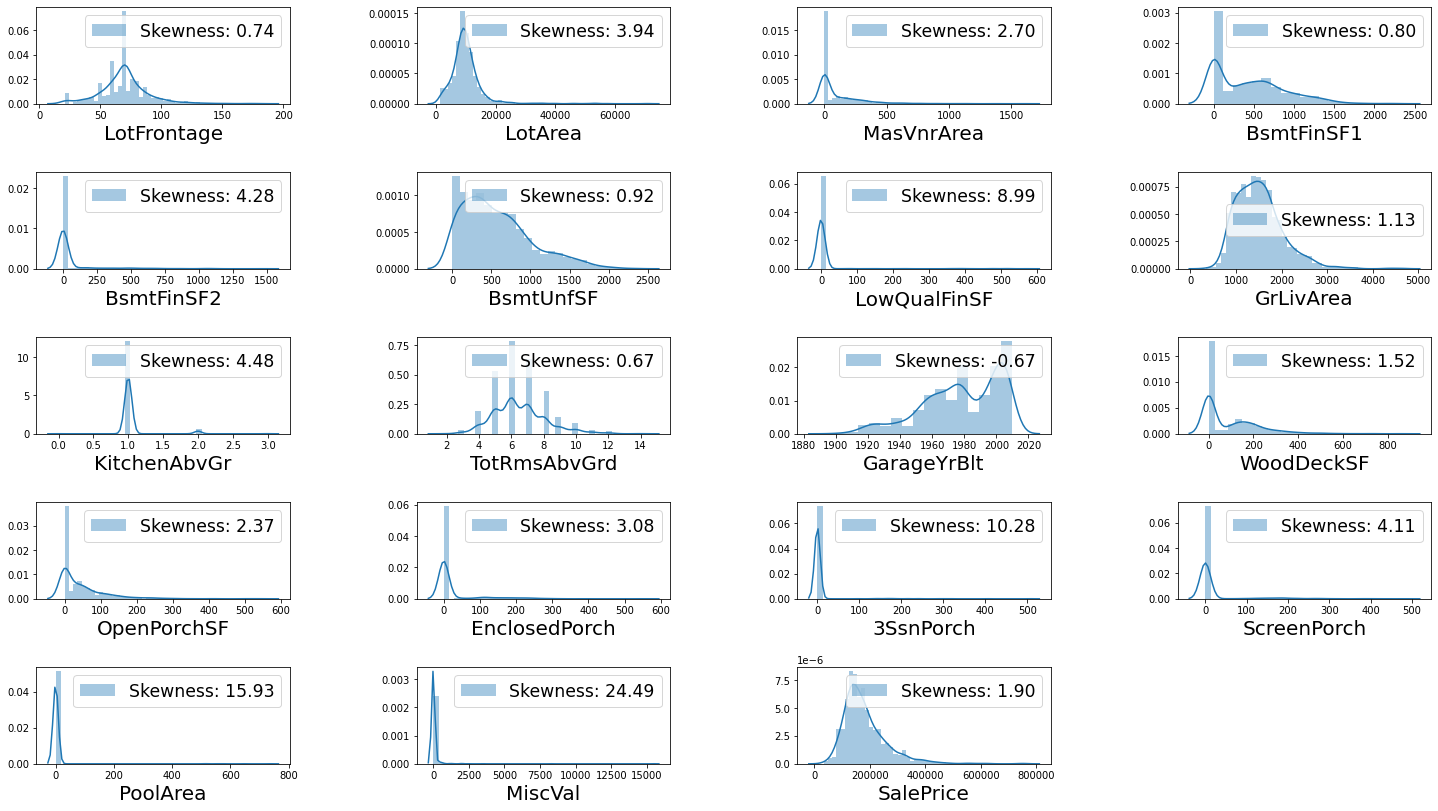

In [57]:
plot_skewed(df=train, skewed=skewed)

По графикам видно, что большинство наших признаков имеют позитивную ассиметрию (или правую). Побороться с данным видос ассиметрии можно с помощью логарифмирования.

Для примера посмотрим на распределение данных целевого признака "SalePrice" до и после логарифмирования. 

Text(0.5, 0, 'SalePrice')

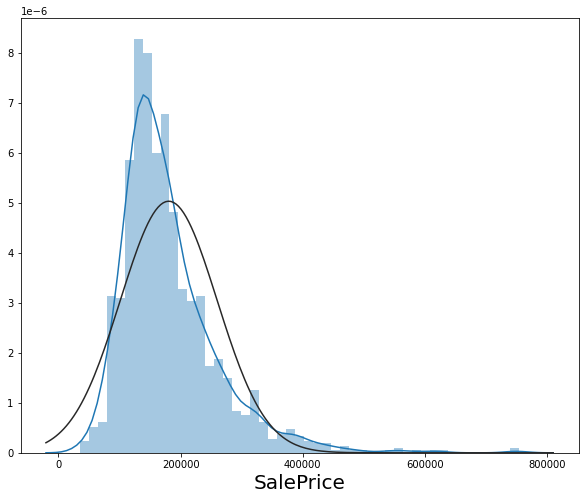

In [58]:
ax = sns.distplot(train['SalePrice'], fit=stats.norm)
ax.set_xlabel('SalePrice', fontsize = 20)

Text(0.5, 0, 'SalePrice')

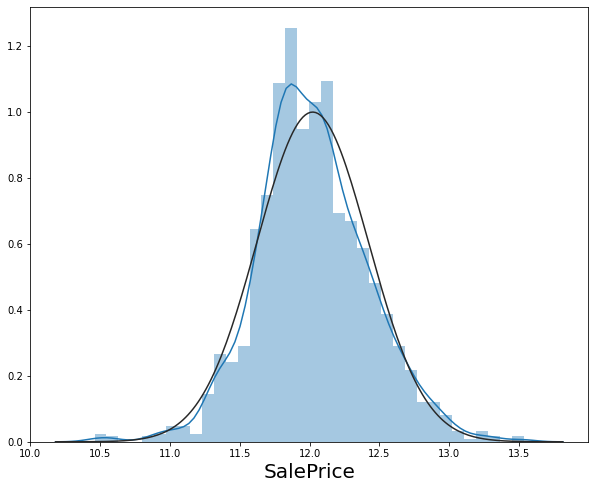

In [59]:
ax = sns.distplot(np.log(train['SalePrice']), fit=stats.norm)
ax.set_xlabel('SalePrice', fontsize = 20)

Видим, что после логарифмирования целевой признак действительно приобрел вид гауссового распределения.

Далее применим логарифмирование для всех числовых признаков в обоих датасетах. 

In [60]:
# так как log() превращает 0 в -inf, то используем функцию log(x+1), которая лучше работает с маленькими значениями
for col in skewed.index:
    train[col] = np.log(train[col] + 1)
    if col == 'SalePrice':
        continue
    test[col] = np.log(test[col] + 1)

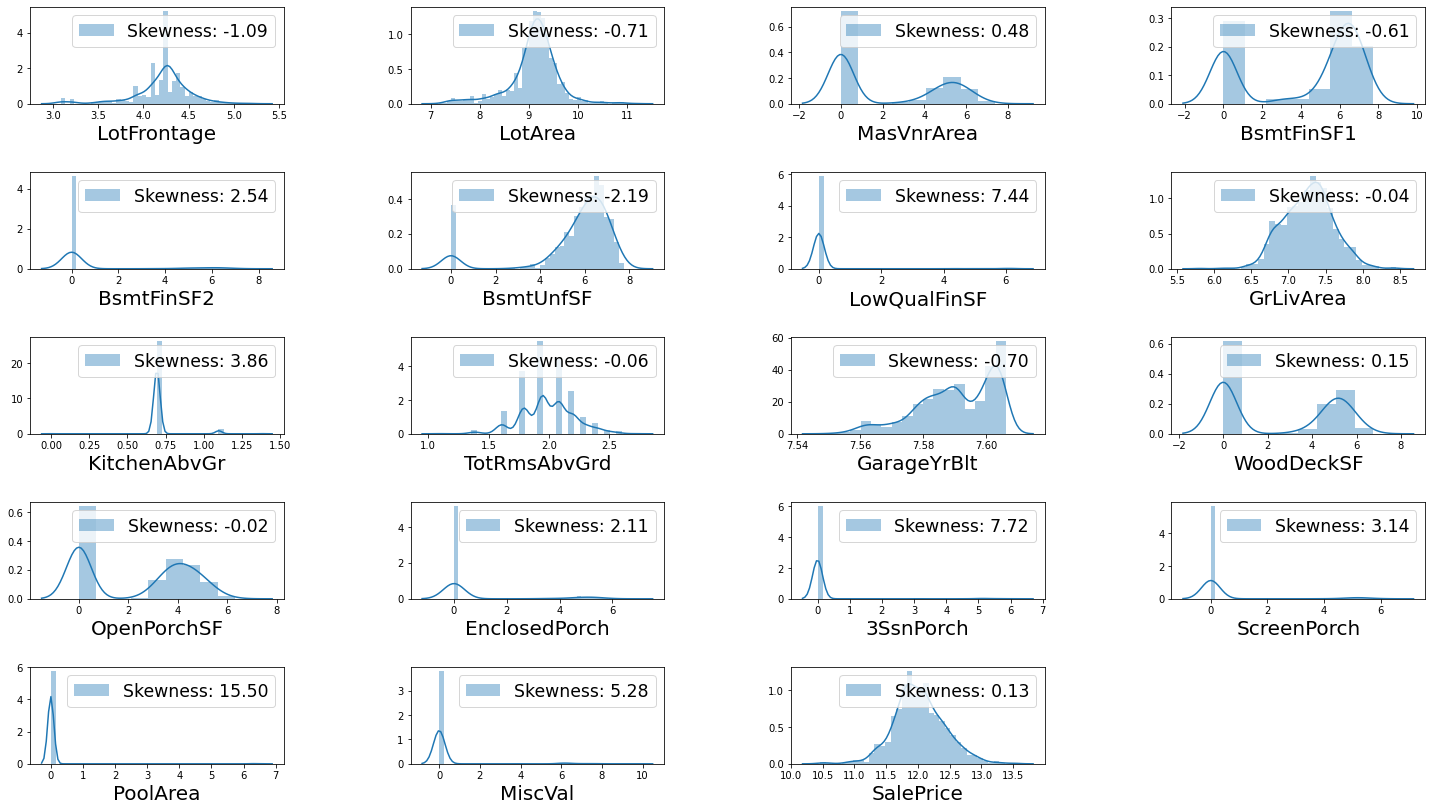

In [61]:
plot_skewed(df=train, skewed=skewed)

In [62]:
skewed = train[numeric_columns].apply(lambda x: stats.skew(x.astype('float')))
skewed = skewed[abs(skewed) > 0.65]
len(skewed)

12

С помощью логарифмирования удалось снизить коэффициент асимметрии у некоторых признаков, однако от остальных, у которых коэффициент велик, можно избавиться.

In [63]:
to_drop = skewed[abs(skewed) > 1]
to_drop

LotFrontage      -1.093353
BsmtFinSF2        2.535243
BsmtUnfSF        -2.183377
LowQualFinSF      7.436501
KitchenAbvGr      3.855987
EnclosedPorch     2.103171
3SsnPorch         7.710341
ScreenPorch       3.138850
PoolArea         15.480172
MiscVal           5.271790
dtype: float64

In [64]:
to_drop = list(to_drop.index)
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
numeric_columns = pd.Index(numeric_columns.drop(to_drop))

In [65]:
del skewed

## 6. Удаление признаков с высоким коэффициентом корреляции

На данном шаге с помощью матрицы корреляции можно установить зависимость среди признаков. Если в датаете присутствует 2 или более признака, чья линейная зависимость близка к единице, то качество модели снизится.

(33.5, -0.5)

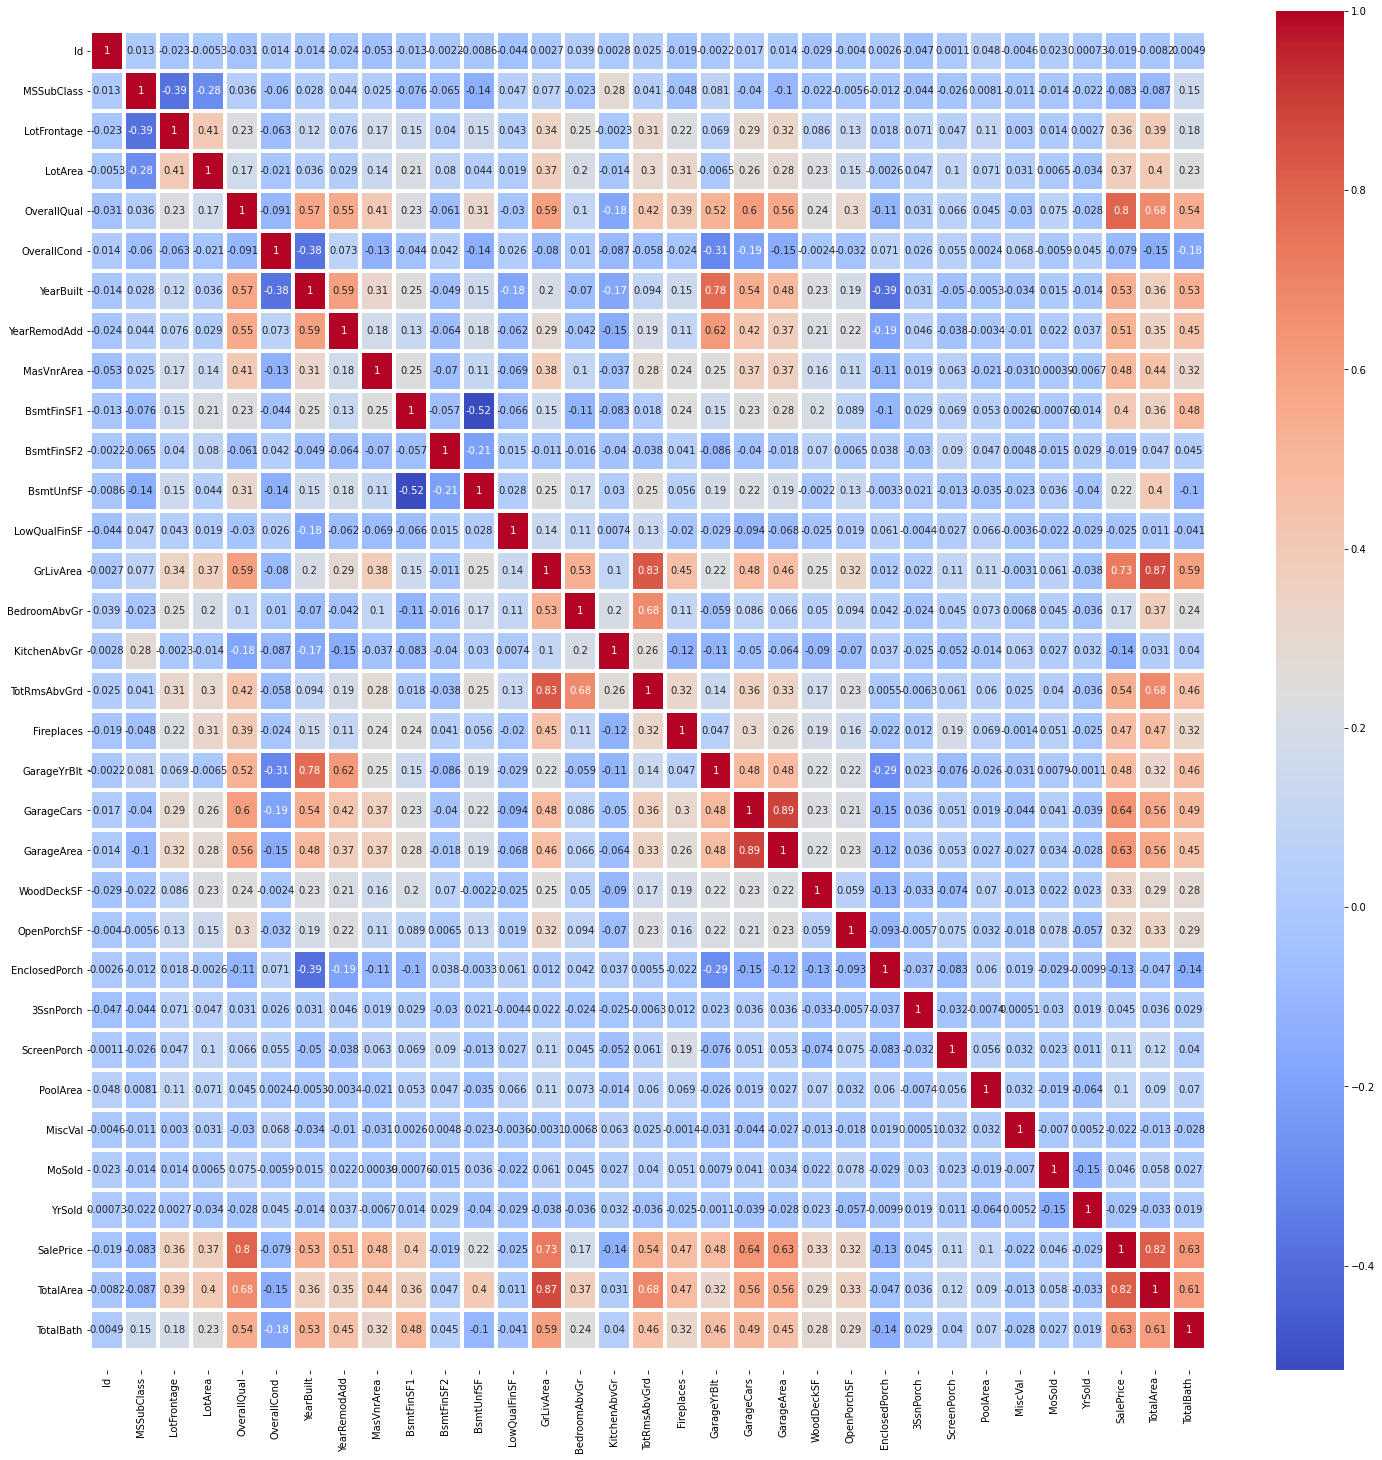

In [53]:
plt.figure(figsize=(25,25))
ax = sns.heatmap(train.corr(), cmap = "coolwarm", annot=True, linewidth=3)

# to fix the bug "first and last row cut in half of heatmap plot"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Посмотрим на признаки с максимальными значениями корреляции по отношению друг к другу

In [54]:
corr = train.corr()
corr_list = list()
for i in range(len(numeric_columns)):
    for j in range(i + 1, len(numeric_columns)):
        col1 = numeric_columns[i];
        col2 = numeric_columns[j];
        if corr[col1][col2] > 0.65:
            corr_list.append((col1, col2, corr[col1][col2]))

In [55]:
list(reversed(sorted(corr_list, key=lambda x: x[-1])))

[('GarageCars', 'GarageArea', 0.8879255985464204),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8288906634780077),
 ('YearBuilt', 'GarageYrBlt', 0.7803761174912148),
 ('GrLivArea', 'SalePrice', 0.7251698662646423),
 ('BedroomAbvGr', 'TotRmsAbvGrd', 0.6784968009707368)]

In [56]:
to_drop = ['GarageCars', 'TotRmsAbvGrd', 'GarageYrBlt']

In [57]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
numeric_columns = numeric_columns.drop(to_drop)

In [58]:
train.shape

(1454, 69)

## 7. Превращение категориальных признаков в числовые

Посмотрим подробнее на каждый категориальный признак

In [59]:
def plot_barh(df, cols, ncols=4):
    num_col = 0
    for i in range(len(cols) // ncols):
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 3), dpi=200)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.5)
        for j in range(ncols):
            num_col += 1
            ax = df[cols[num_col]].value_counts().plot.barh(ax=axes[j])
            ax.set_xlabel(cols[num_col], fontsize = 10)

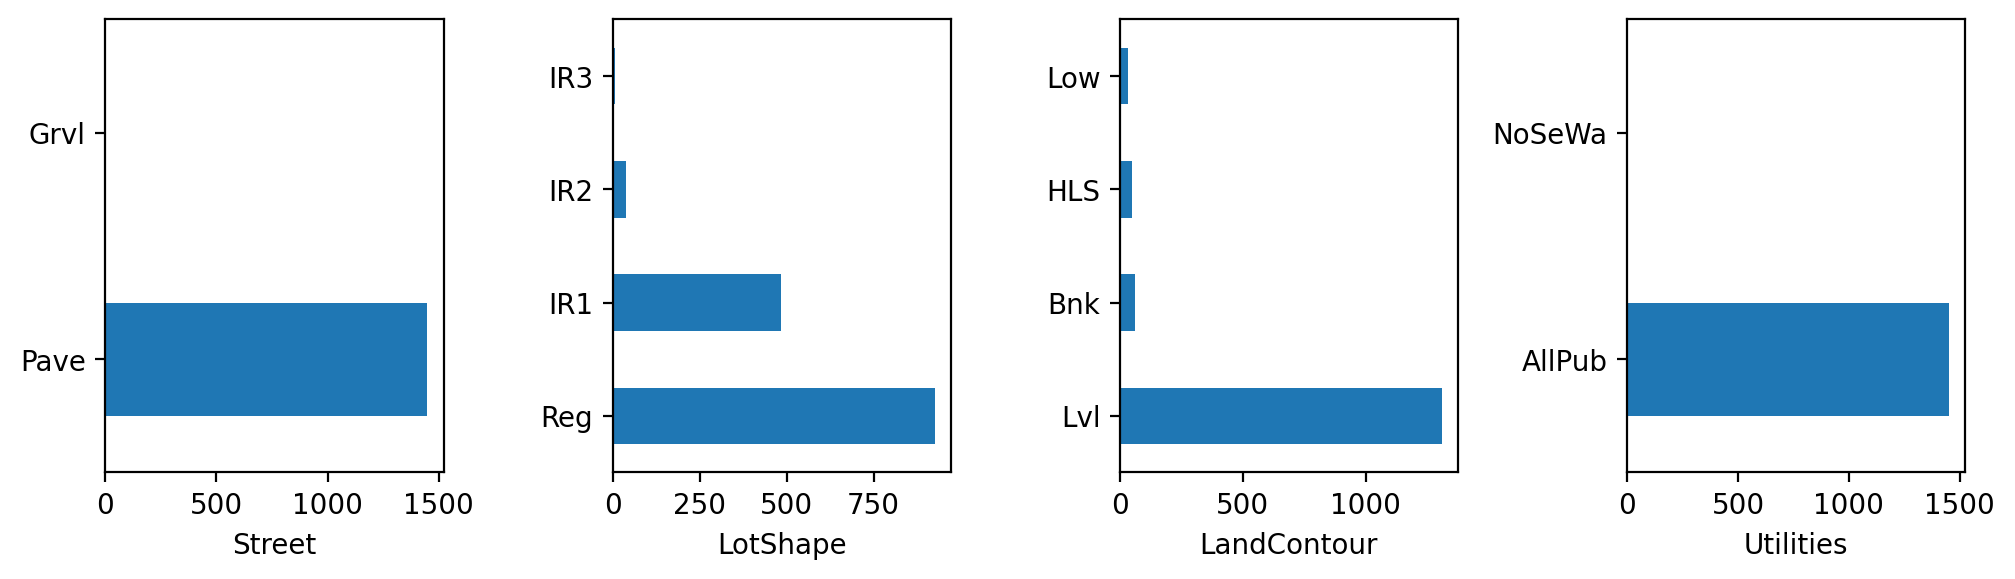

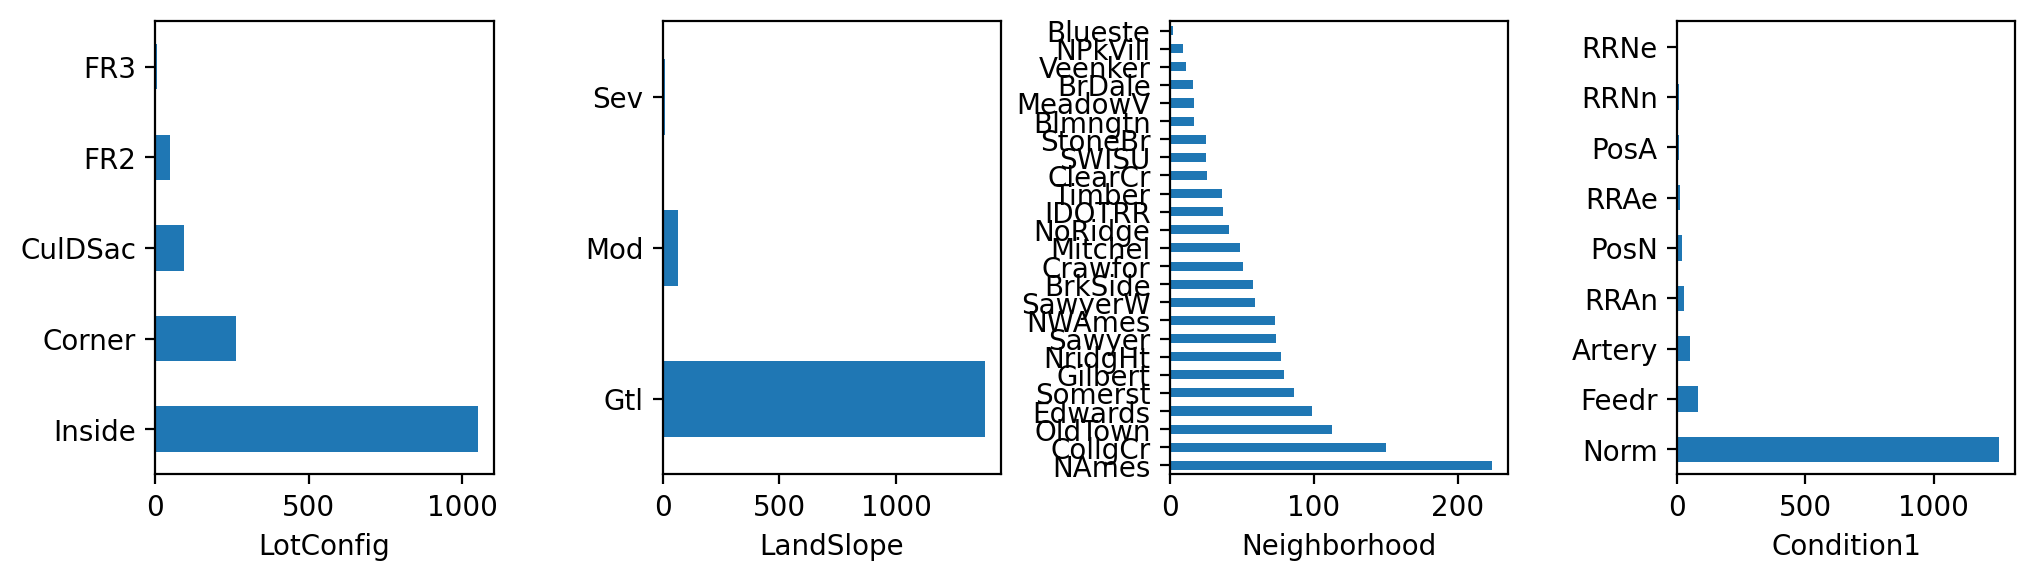

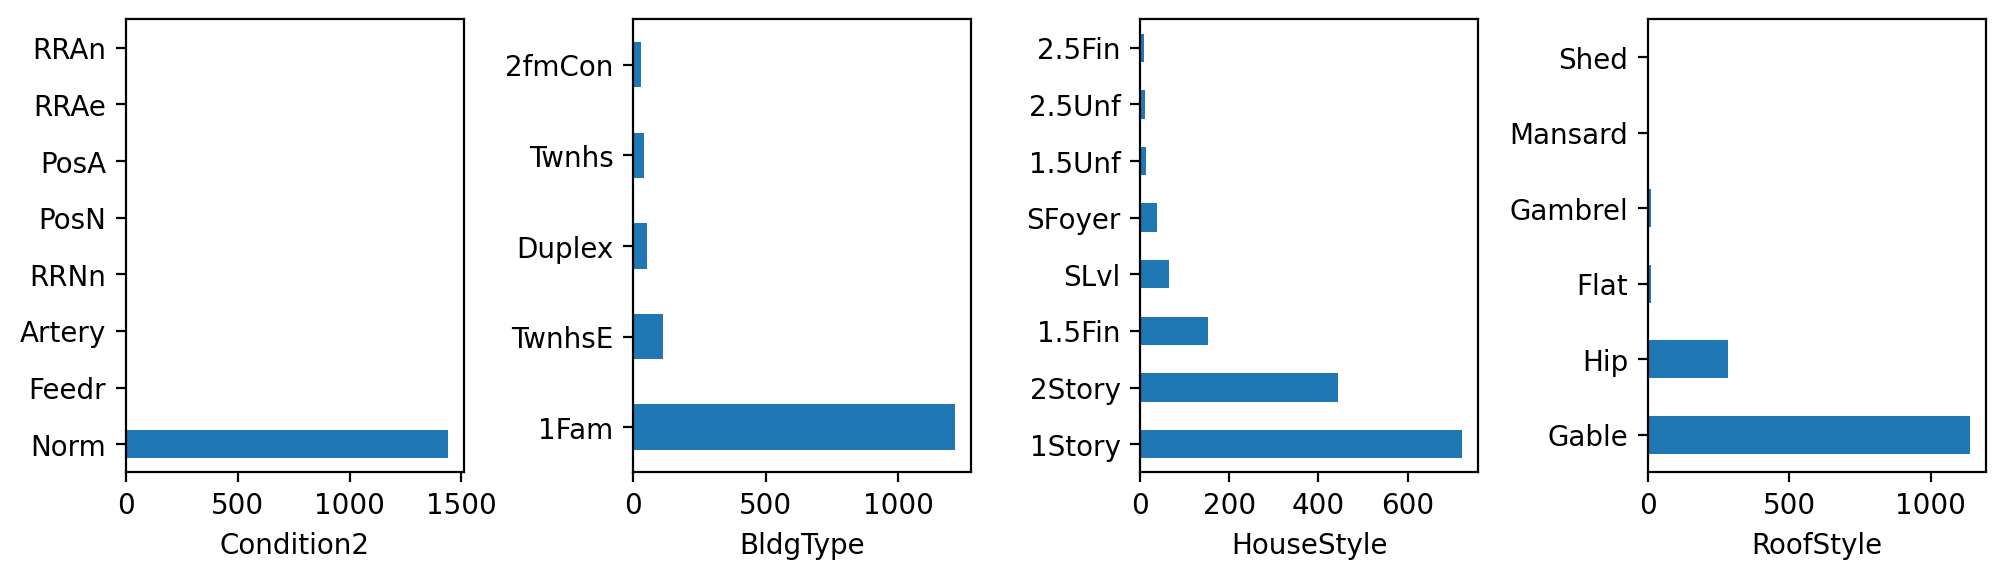

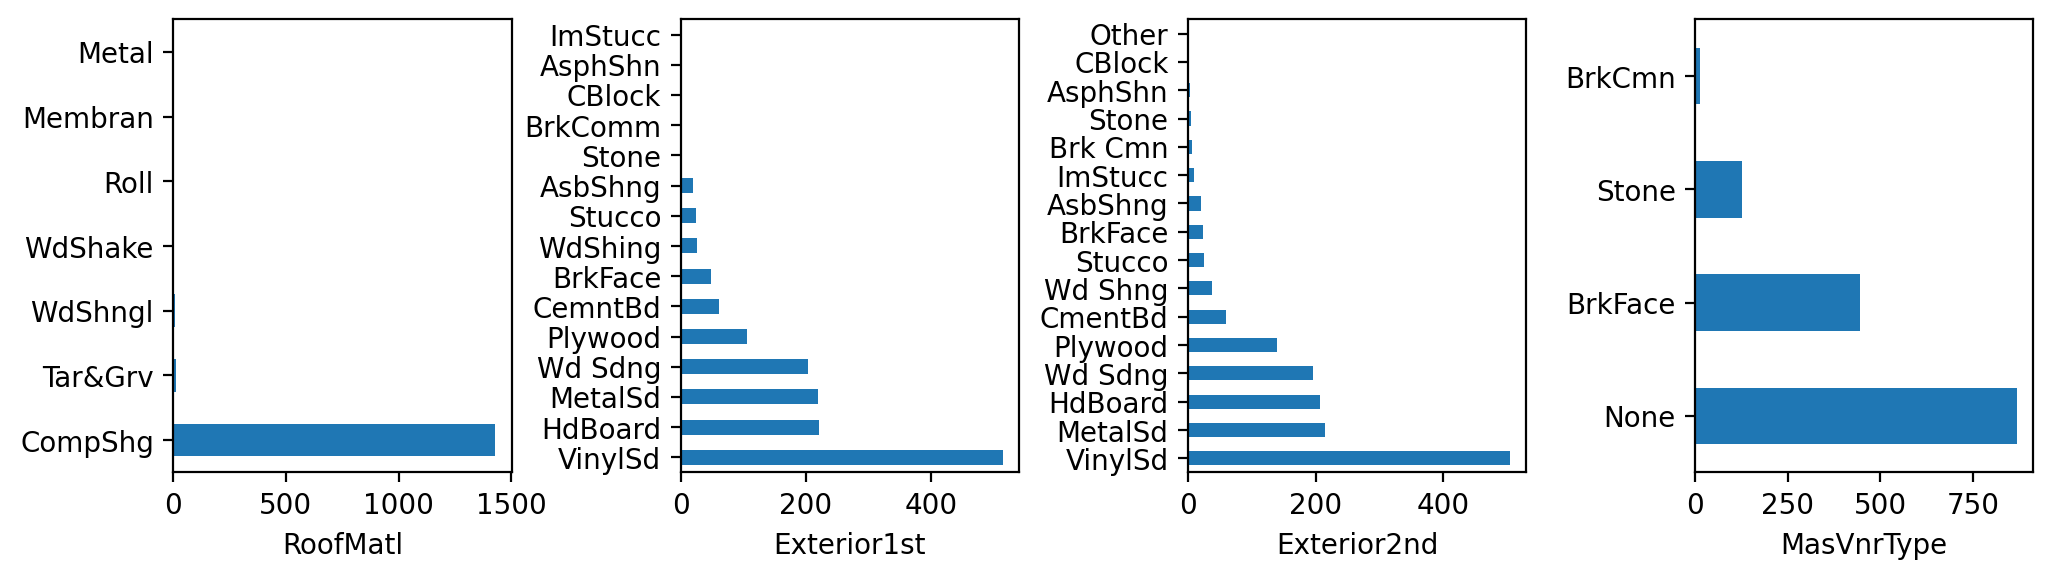

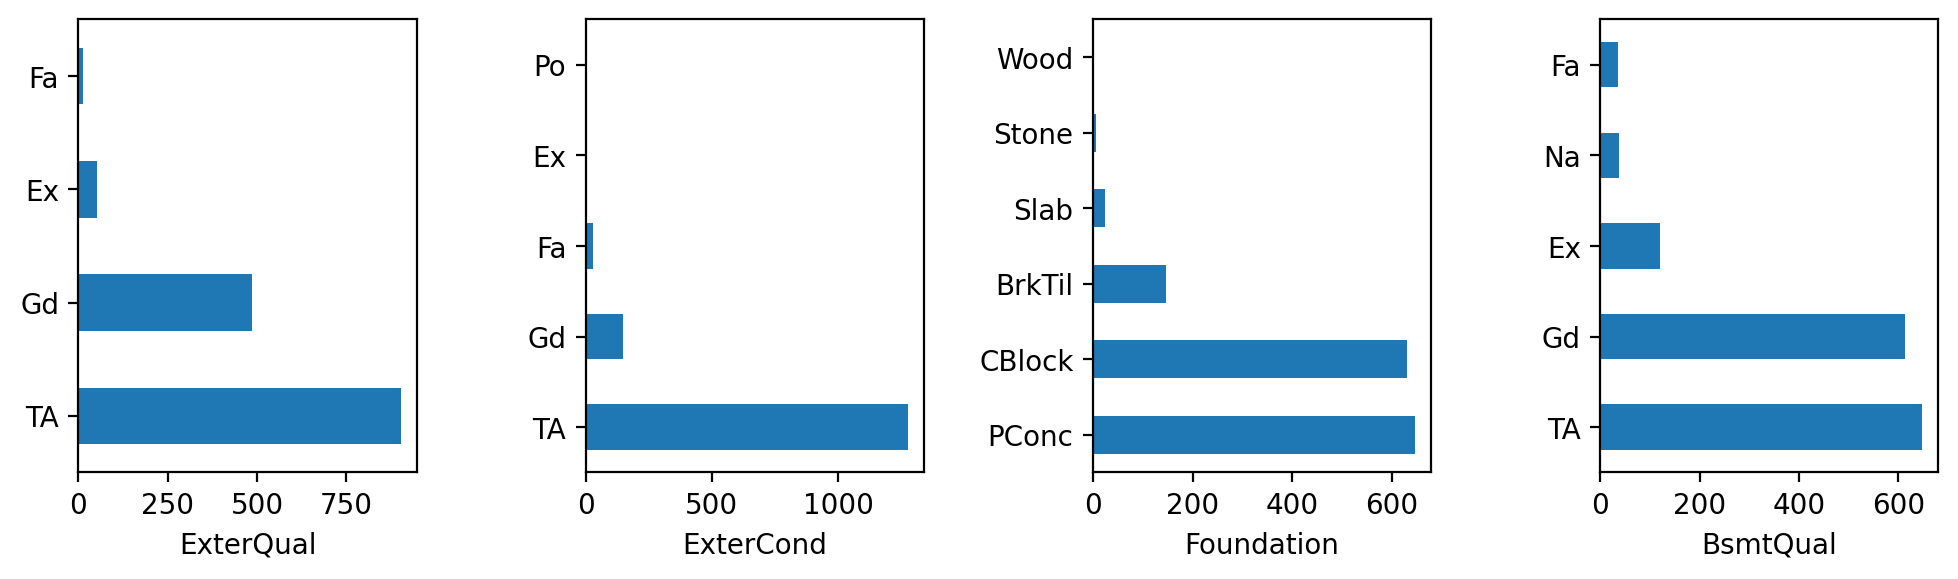

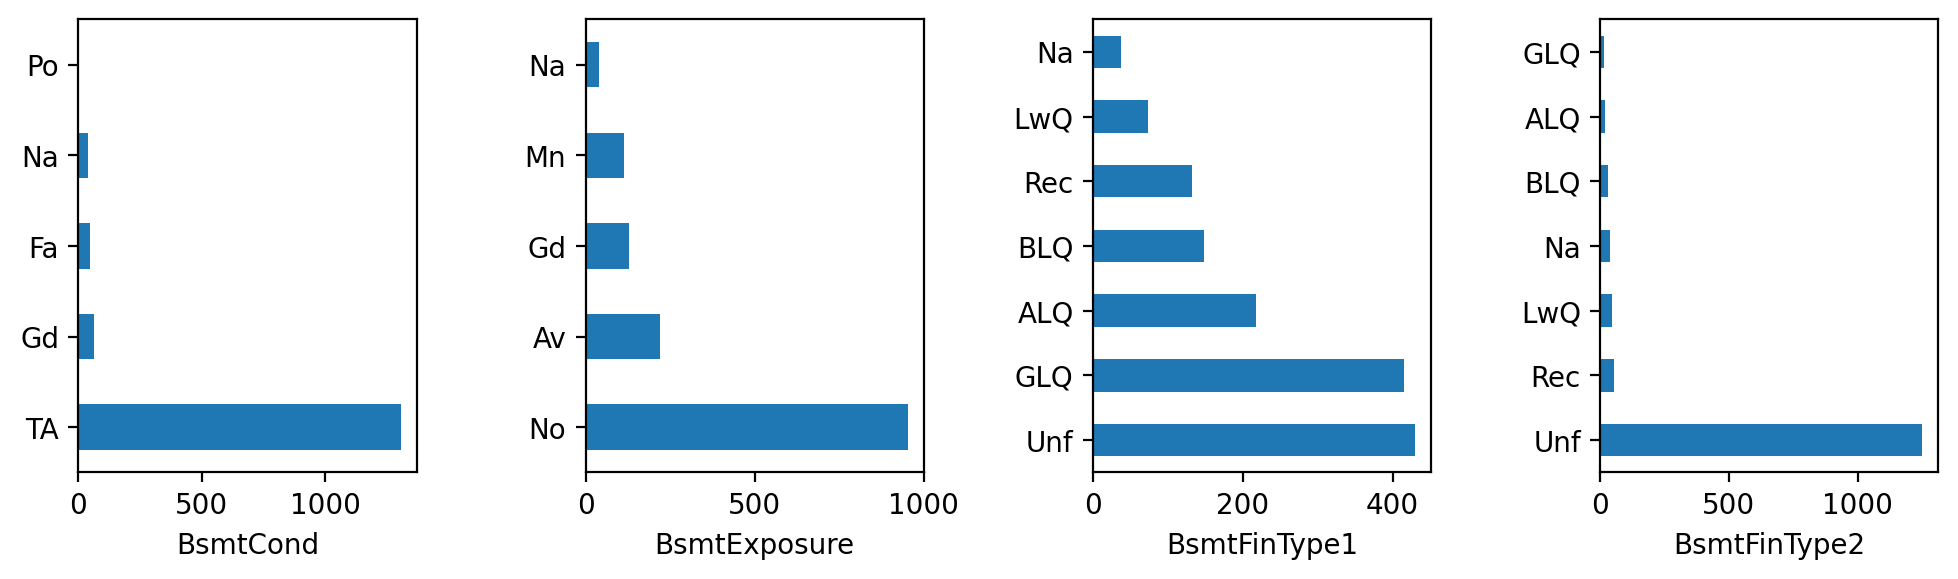

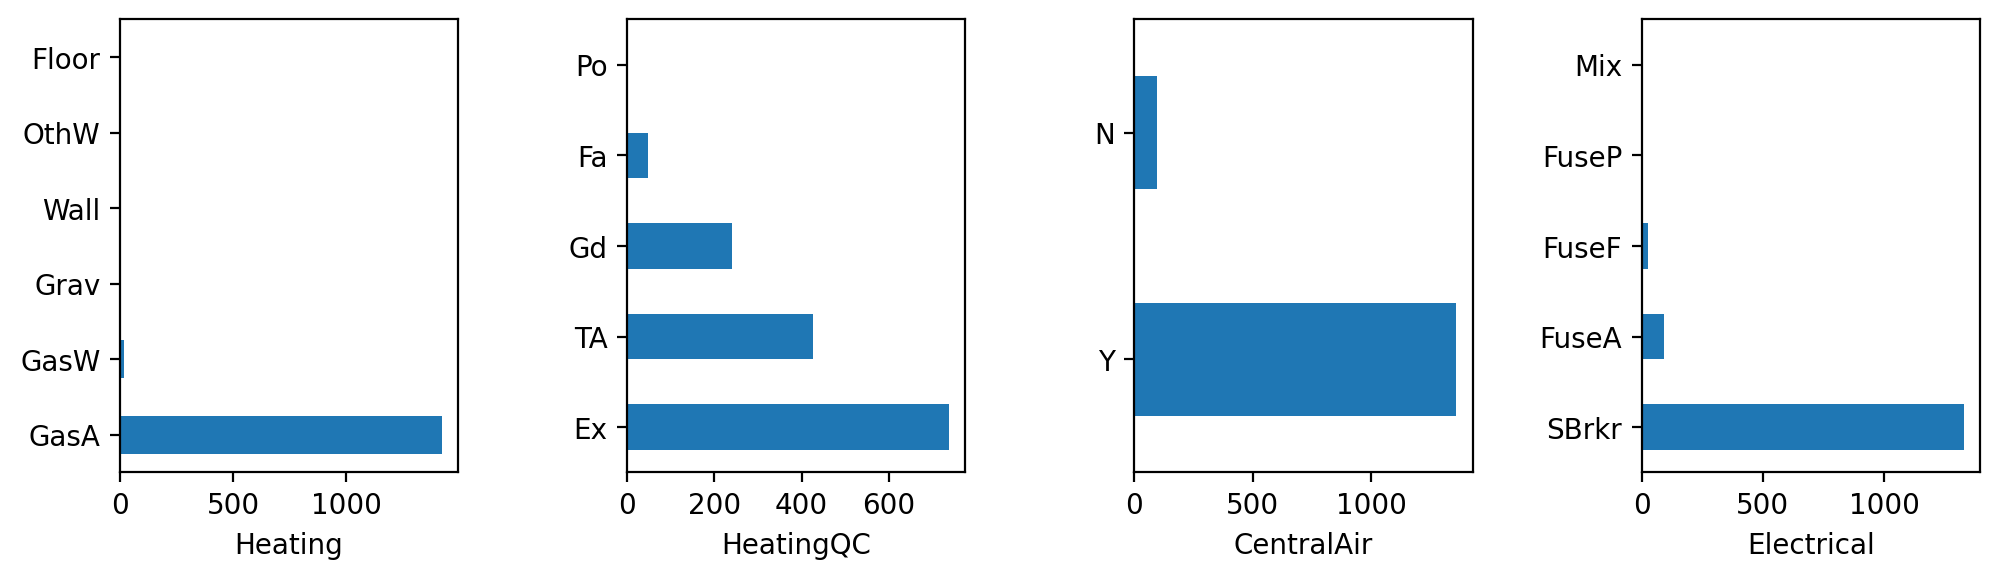

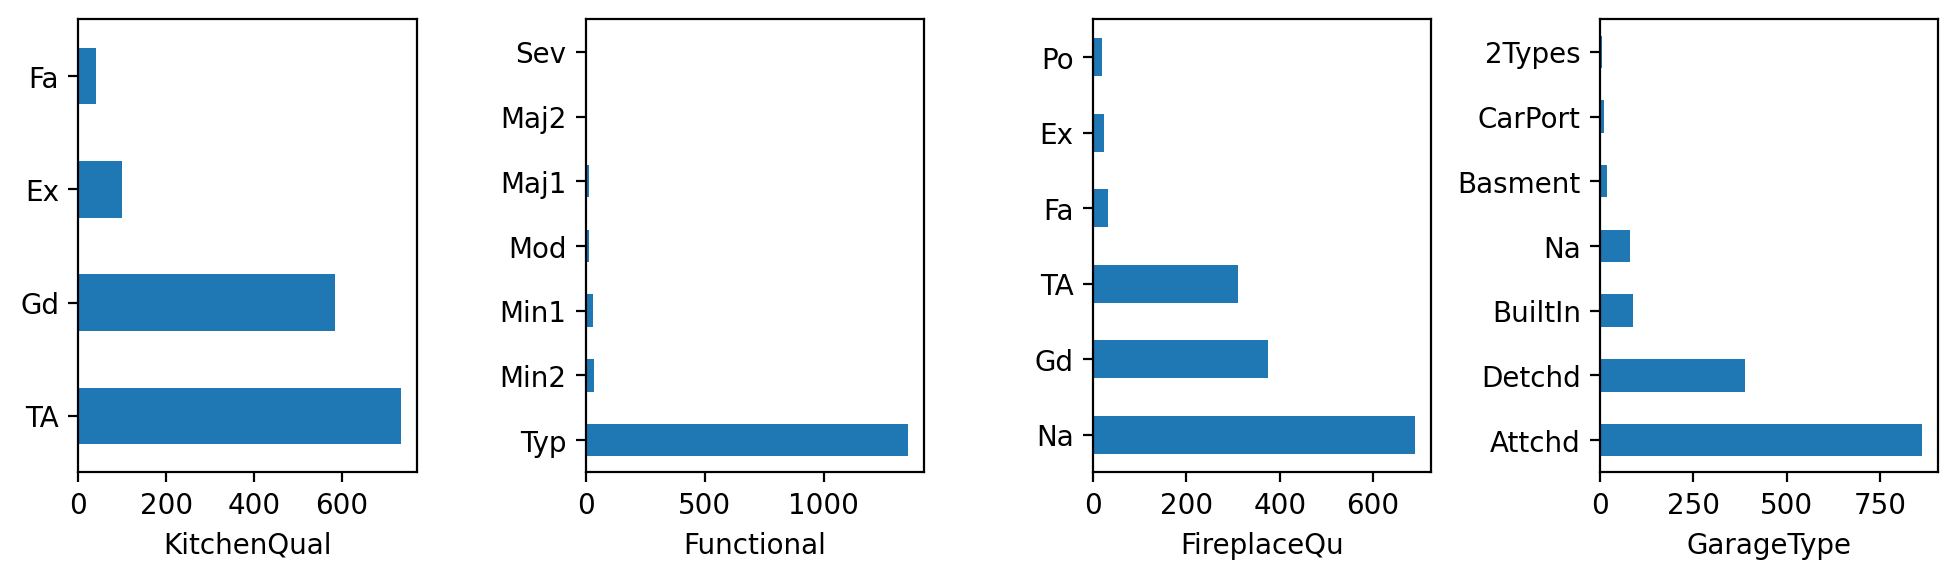

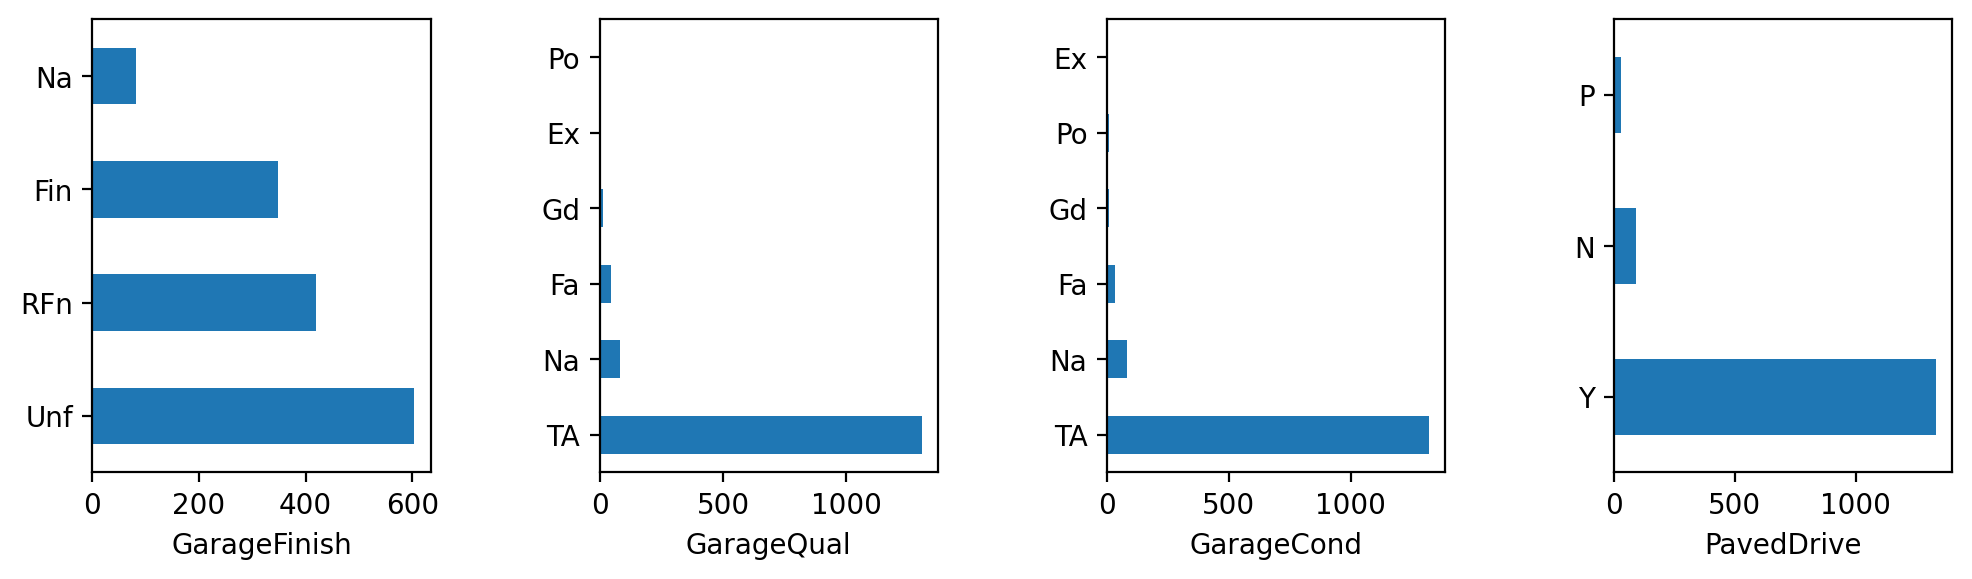

In [60]:
plot_barh(df=train, cols=object_columns)

Имеется несколько признаков, в которых одна категория значительно преобладает над другими.  

Например:

In [61]:
train['Utilities'].value_counts()
train['Heating'].value_counts()

GasA     1423
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Подобные признаки не смогут положительно повлиять на качество нашей модели.

In [62]:
to_drop = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'] # 'RoofMatl', 'Heating'] ???

In [63]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
object_columns = object_columns.drop(to_drop)

In [64]:
train.shape

(1454, 64)

Длаее категории строчного типа следует привести к вещественному.
Однозначно отобразим каждое значение в уникальное число с помощью класса LabelEncoder библиотеки sklearn. Алгоритм случайного леса не является линейным алгоритмом, следоветльно, такой вид преобразования не скажется негативно на качетсве модели.

In [65]:
label_encoder = LabelEncoder()

for col in object_columns:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalArea,TotalBath
0,1,60,3,65.0,8450,3,3,4,0,5,2,0,5,7,5,2003,2003,1,12,13,1,196.0,2,4,2,2,4,4,2,706,6,0,150,0,1,4,0,1710,3,1,2,6,0,3,1,2,548,5,5,2,0,61,0,0,0,0,0,2,2008,8,4,208500,2566,3.5
1,2,20,3,80.0,9600,3,3,2,0,24,1,0,2,6,8,1976,1976,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,0,1,4,0,1262,3,1,3,6,1,5,1,2,460,5,5,2,298,0,0,0,0,0,0,5,2007,8,4,181500,2524,2.5
2,3,60,3,68.0,11250,0,3,4,0,5,2,0,5,7,5,2001,2002,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,0,1,4,0,1786,3,1,2,6,1,5,1,2,608,5,5,2,0,42,0,0,0,0,0,9,2008,8,4,223500,2706,3.5
3,4,70,3,60.0,9550,0,3,0,0,6,2,0,5,7,5,1915,1970,1,13,15,2,0.0,3,4,0,4,1,4,0,216,6,0,540,2,1,4,0,1717,3,1,2,6,1,2,5,3,642,5,5,2,0,35,272,0,0,0,0,2,2006,8,0,140000,2473,2.0
4,5,60,3,84.0,14260,0,3,2,0,15,2,0,5,8,5,2000,2000,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,0,1,4,0,2198,4,1,2,6,1,5,1,2,836,5,5,2,192,84,0,0,0,0,0,12,2008,8,4,250000,3343,3.5


Данные готовы для обучения!

In [66]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalArea,TotalBath
0,1,60,3,65.0,8450,3,3,4,0,5,2,0,5,7,5,2003,2003,1,12,13,1,196.0,2,4,2,2,4,4,2,706,6,0,150,0,1,4,0,1710,3,1,2,6,0,3,1,2,548,5,5,2,0,61,0,0,0,0,0,2,2008,8,4,208500,2566,3.5
1,2,20,3,80.0,9600,3,3,2,0,24,1,0,2,6,8,1976,1976,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,0,1,4,0,1262,3,1,3,6,1,5,1,2,460,5,5,2,298,0,0,0,0,0,0,5,2007,8,4,181500,2524,2.5
2,3,60,3,68.0,11250,0,3,4,0,5,2,0,5,7,5,2001,2002,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,0,1,4,0,1786,3,1,2,6,1,5,1,2,608,5,5,2,0,42,0,0,0,0,0,9,2008,8,4,223500,2706,3.5
3,4,70,3,60.0,9550,0,3,0,0,6,2,0,5,7,5,1915,1970,1,13,15,2,0.0,3,4,0,4,1,4,0,216,6,0,540,2,1,4,0,1717,3,1,2,6,1,2,5,3,642,5,5,2,0,35,272,0,0,0,0,2,2006,8,0,140000,2473,2.0
4,5,60,3,84.0,14260,0,3,2,0,15,2,0,5,8,5,2000,2000,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,0,1,4,0,2198,4,1,2,6,1,5,1,2,836,5,5,2,192,84,0,0,0,0,0,12,2008,8,4,250000,3343,3.5


In [67]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalArea,TotalBath
0,1461,20,2,80.0,11622,3,3,4,0,12,1,0,2,5,6,1961,1961,1,10,12,2,0.0,3,4,1,4,4,4,5,468.0,3,144.0,270.0,4,1,3,0,896,2,1,3,6,0,3,1,3,730.0,4,5,2,140,0,0,0,120,0,0,6,2010,8,4,1778.0,1.0
1,1462,20,3,81.0,14267,0,3,0,0,12,2,0,2,6,6,1958,1958,3,11,13,1,108.0,3,4,1,4,4,4,0,923.0,6,0.0,406.0,4,1,3,0,1329,3,1,2,6,0,3,1,3,312.0,4,5,2,393,36,0,0,0,0,12500,6,2010,8,4,2658.0,1.5
2,1463,60,3,74.0,13830,0,3,4,0,8,2,0,4,5,5,1997,1998,1,10,12,2,0.0,3,4,2,2,4,4,2,791.0,6,0.0,137.0,2,1,3,0,1629,3,1,3,6,1,5,1,0,482.0,4,5,2,212,34,0,0,0,0,0,3,2010,8,4,2557.0,2.5
3,1464,60,3,78.0,9978,0,3,4,0,8,2,0,4,6,6,1998,1998,1,10,12,1,20.0,3,4,2,4,4,4,2,602.0,6,0.0,324.0,0,1,3,0,1604,3,1,2,6,1,2,1,0,470.0,4,5,2,360,36,0,0,0,0,0,6,2010,8,4,2530.0,2.5
4,1465,120,3,43.0,5005,0,1,4,0,22,2,4,2,8,5,1992,1992,1,6,6,2,0.0,2,4,2,2,4,4,0,263.0,6,0.0,1017.0,0,1,3,0,1280,2,1,2,6,0,3,1,2,506.0,4,5,2,0,82,0,0,144,0,0,1,2010,8,4,2560.0,2.0


## Обучение модели

In [73]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test
y_test = pd.read_csv('data/sample_submission.csv')['SalePrice']

In [74]:
X_test.shape

(1459, 63)

In [75]:
X_train.shape

(1454, 63)

### Решающее дерево

In [87]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)
np.sqrt(mean_squared_error(d_predict, y_test))

78365.80521901847

score from Kaggle: 0.21018

### Бэггинг решающих деревьев

In [89]:
# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)
np.sqrt(mean_squared_error(bdt_predict, y_test))

74031.78007128563

score from Kaggle: 0.15519

### Случайны лес без настройки параметров

In [90]:
# Random Forest
forest = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
forest_predict = forest.predict(X_test)
np.sqrt(mean_squared_error(forest_predict, y_test))

72477.28796936627

score from Kaggle: 0.16415

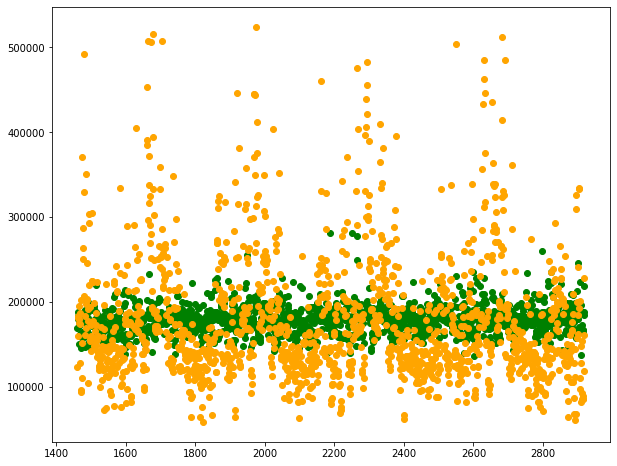

In [93]:
plt.scatter(X_test['Id'], y_test, c='green')
plt.scatter(X_test['Id'], forest_predict, c='orange')

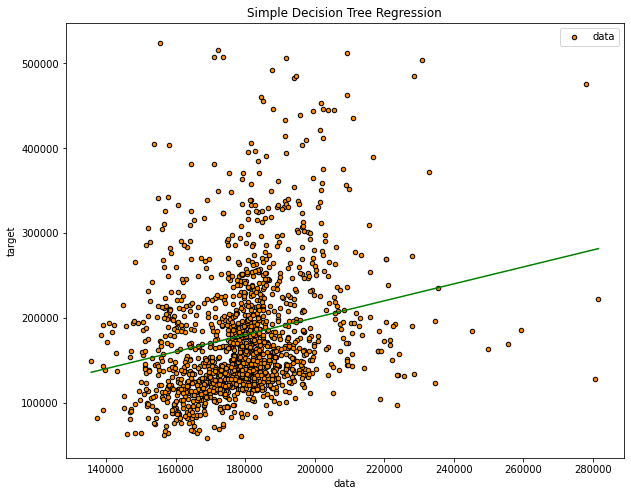

In [94]:
# Plot the results
plt.figure()
plt.scatter(y_test, forest_predict, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c="green")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Simple Decision Tree Regression")
plt.legend()
plt.show()

### Случайны лес с настройкой параметров

In [99]:
n_estimators = [100, 300, 500, 800]
max_features = [0.2, 0.3, 0.4]
max_depths = [10, 20]
min_samples_leaves = [1, 3, 5]

params = {
    "n_estimators": n_estimators, 
    "max_features": max_features,
    "max_depth": max_depths,
    "min_samples_leaf": min_samples_leaves
}

rf = RandomForestRegressor(n_jobs=-1, verbose=2)
est = GridSearchCV(rf, param_grid=params)

In [ ]:
%%time
est.fit(X_train, y_train).best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | ela

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend L

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | ela

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with

In [ ]:
# На данный момент это лучший вариант:

In [91]:
params = {
    "n_jobs": -1, 
    'max_depth': 20, 
    'max_features': 0.4, 
    'min_samples_leaf': 1, 
    'n_estimators': 800
}
rf = RandomForestRegressor(**params).fit(X_train, y_train)
predict_test = rf.predict(X_test)
predict_train = rf.predict(X_train)

In [92]:
err_test = mean_squared_error(predict_test, y_test)
print("MSE:", err_test)

MSE: 0.13689303350518067


In [93]:
err_test = mean_squared_error(predict_test, y_test)
print("RMSE:", np.sqrt(err_test))

RMSE: 0.3699905856980427


In [94]:
print("Случайный лес, MSE = %.2f" % np.sqrt(np.sum((y_test - predict_test) ** 2)))

Случайный лес, MSE = 14.13


In [95]:
predict_test = rf.predict(X_test)
predict_train = rf.predict(X_train)

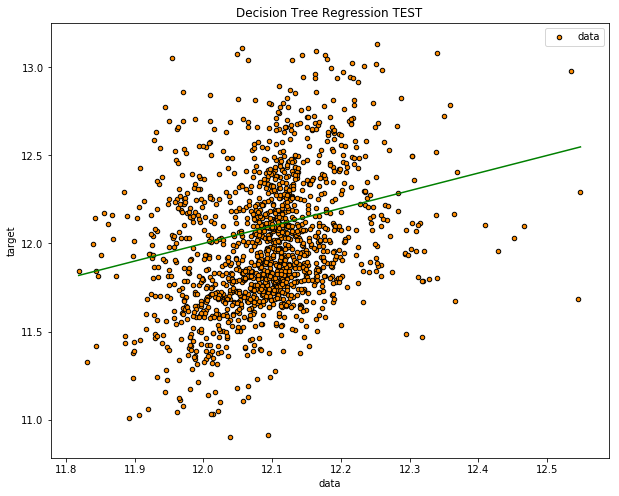

In [96]:
# Plot the results
plt.figure()
plt.scatter(y_test, predict_test, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c="green")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression TEST")
plt.legend()
plt.show()

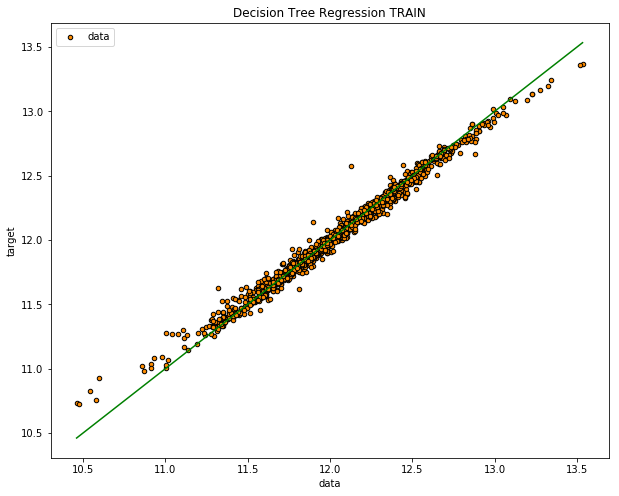

In [97]:
# Plot the results
plt.figure()
plt.scatter(y_train, predict_train, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], c="green")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression TRAIN")
plt.legend()
plt.show()

In [98]:
submission = pd.DataFrame({'Id' : test['Id'], 'SalePrice' : np.expm1(predict_test)})
submission.to_csv("./submission-rf-26_05_2020.csv", index=False)

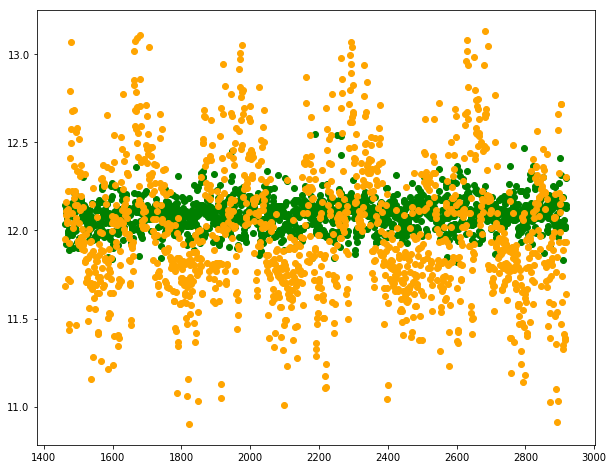

In [100]:
plt.scatter(X_test['Id'], y_test, c='green')
plt.scatter(X_test['Id'], predict_test, c='orange')

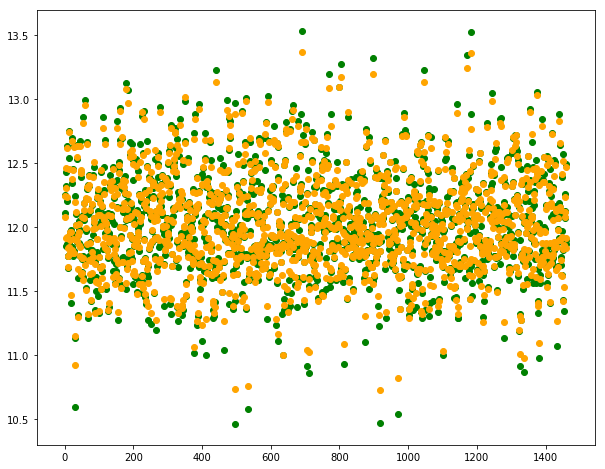

In [101]:
plt.scatter(train['Id'], y_train, c='green')
plt.scatter(train['Id'], predict_train, c='orange')

In [ ]:
# # Визуализация одного дерева

# single_tree = rf.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(single_tree, out_file='tree.dot', 
#                 feature_names = train.columns[1:-1],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')